# Homework 5
## Due Thursday Apr. 3rd

### Fitting a parabola

Let's quickly create some fake data of a projectile traveling under the influence of gravity.

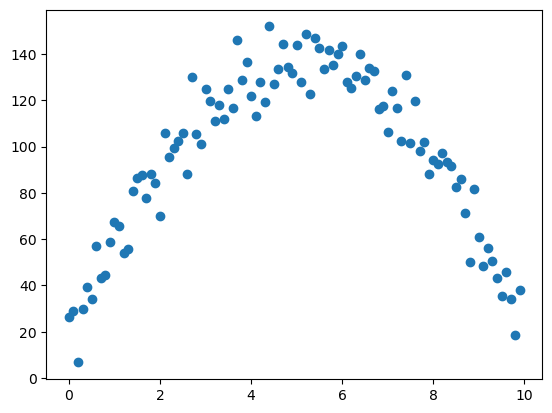

In [14]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource
from scipy.optimize import minimize, curve_fit

t = np.arange(0, 10, 0.1)
y = 10 + 50*t - 9.8*t**2/2
noisy = y + np.random.randn(len(y)) * 10

plt.scatter(t, noisy)

Now we'll conveniently forget that we "knew" acceleration due to gravity for the sake of this exercise. 

We will however remember that objects in motion under the influence of a constant acceleration, in a vacuum, move according to the equation $ x = x_0 + v\cdot t $+$ a\cdot t^2 \over 2$.

We should be able to recover the acceleration due to gravity by finding the three coefficients of a second degree polynomial fit to our fake data (use `noisy`, not `y`).

- a) Write a 2nd degree polynomial function then use $\chi^2$ minimization to find the three best fit coefficients (25 pts)

- b) Plot your best fit results to confirm the goodness of fit (5 pts)

- c) Solve for acceleration due to gravity! (Pretend it's a real problem; I could have given you the data but I figured it was easier to generate it) (5 pts)

Hint: If you're having trouble, try using the Nelder Mead algorithm provided in class; it should converge quickly

In [15]:
def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):

    # init
    dim = len(x_start)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres

[-5.18409594 53.1606504   1.53878663]
The value of gravity, according to this data and fit, is -10.368191878997031


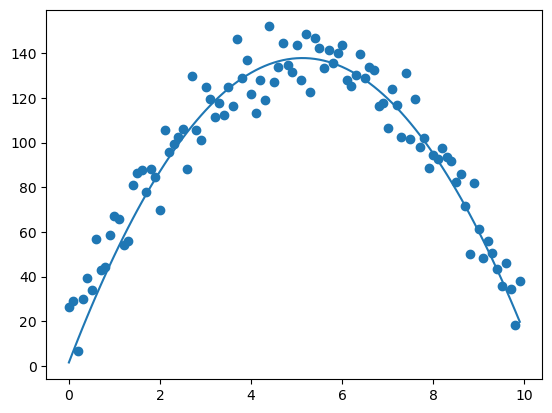

In [16]:
# code
def quad(x,a,b,c):
    return a*x**2 + b*x + c
    
# Copy and Paste code for chi squared fitting....
class SquareChi(object):
    def __init__(self,x,y,func):
        self.xdat = x
        self.ydat = y
        self.func = func
        
    def __call__(self,args):
        chai = (self.ydat -  self.func(self.xdat,*args)) / self.ydat
        chai2 = np.sum(chai**2) / len(self.xdat)
        return chai2

chi = SquareChi(t, noisy, quad)
# Yes this is just the t plot code but it varies for all paramters of the quadratic
a_plot = np.arange(-5,5,.1)
b_plot = np.arange(-5,5,.1)
c_plot = np.arange(-5,5,.1)

A,B,C = np.meshgrid(a_plot,b_plot,c_plot)
z = np.zeros_like(A)

for i in range(len(A)):
    for j in range(len(B)):
        for k in range(len(C)):
            z[i,j,k] = chi((A[i,j,k],B[i,j,k],C[i,j,k]))
# Flatten the a_plot,b_plot,c_plot or A,B,C or something to get the initial guess.
index = np.argmin(z.flatten())
aguess = A.flatten()[index]
bguess = B.flatten()[index]
cguess = C.flatten()[index]

guess = (aguess,bguess,cguess)

best, score = nelder_mead(chi, np.array(guess, float))
print(best)

plt.scatter(t,noisy)
plt.plot(t,quad(t,best[0],best[1],best[2]))

print("The value of gravity, according to this data and fit, is " + str(best[0]*2))

### You wrote a gradient descent algorithm, right?

As promised, the other half of this assignment requires your own implementation of a gradient descent algorithm.

Below I have defined a simple function, $2 \sin x + 1$. Your 2-D/N-D gradient descent algorithm should be able to find a reasonable answer with little trouble.

- a) Use your gradient descent algorithm to find the best fit line using chi-square minimization. Feel free to use the existing `line` function in your fitting; you can assume the form and just find coefficients. Make sure the code you wrote for gradient descent is in your turned in assignment. (40 pts)

- b) Plot your best fit results to confirm the goodness of fit (5 pts)

- c) Plot the chi-square surface that along which you descended; feel free to copy-paste the 3-D plotting code from class. (5 pts, +5 bonus** points if you plot the path your algorithm took down the slope)



** I don't think I can enter > 100 in the grade book but if you're already at full credit you probably don't need the bonus right?

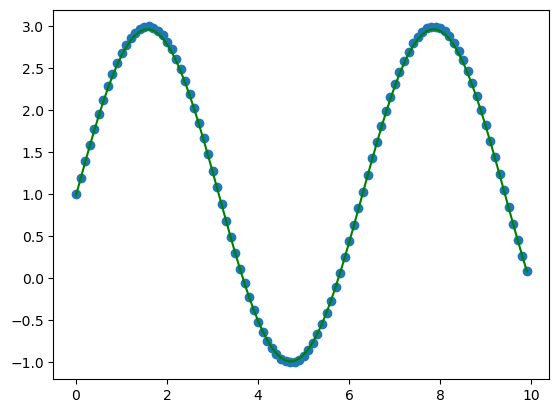

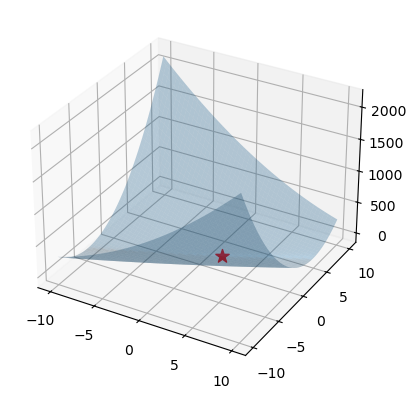

In [17]:
def line(x, m, b):
    return m*np.sin(x) + b

x = np.arange(0, 10, 0.1)
y = line(x, 2, 1)

# code for minimizing; this is what I used in class. (Slight alteration to make it work)
def grad_NDescent(function, start,step,accuracy, move=False):
    deriv = np.zeros_like(start)
    for i in range(0,len(start)):
        term = np.zeros_like(start)
        term[i] = step/2
        deriv[i] = (function(start + term) - function(start - term) ) / step
    start -= deriv * step
    cond1 = np.sqrt(np.sum(deriv**2)) * step
    terminator = 1
    movement = np.array(start)
    steps = 1
    while cond1 > ((10**(-1*accuracy))):
        for i in range(0,len(start)):
            term = np.zeros_like(start)
            term[i] = step/2
            deriv[i] = (function(start + term) - function(start - term) ) / step
        start -= deriv * step
        cond1 = np.sqrt(np.sum(deriv**2)) * step
        terminator += 1
        if (terminator < 10):
            mvmtcopy = np.append(movement, np.array(start))
            movement = mvmtcopy
            steps += 1
        if (terminator % 75 == 0):
            mvmtcopy = np.append(movement, np.array(start))
            movement = mvmtcopy
            steps += 1
        if terminator > 999:
            print("Broke")
            break
    if move == True:
        mvmtcopy = np.append(movement, np.array(start))
        movement = mvmtcopy
        steps += 1
        return movement, steps
    else:
        return start



chi = SquareChi(x,y,line)

m_plot = np.linspace(-10, 10, 100)
b_plot = np.linspace(-10, 10, 100)
x_plot, y_plot = np.meshgrid(m_plot, b_plot)
z = np.zeros_like(x_plot)


for i in range(len(x_plot)):
    for j in range(len(x_plot)):
        z[i,j] = chi((x_plot[i,j],y_plot[i,j]))

index = np.argmin(z.flatten())
mguess = x_plot.flatten()[index]
bguess = y_plot.flatten()[index]

start = [1,line(1,mguess,bguess)]
best = grad_NDescent(chi,np.array(start,float),.01,4)

plt.scatter(x,y)
plt.plot(x,line(x,best[0],best[1]),c = "green")



fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

surf = ax.plot_surface(x_plot, y_plot, z, alpha=0.3)
ax.scatter(best[0], best[1], chi((best[0], best[1])), marker="*", s=100, color="r")

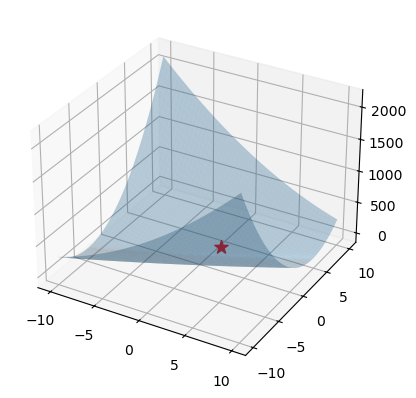

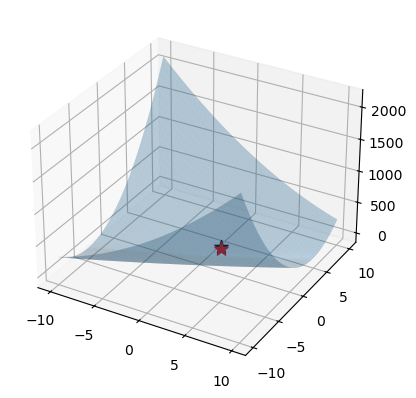

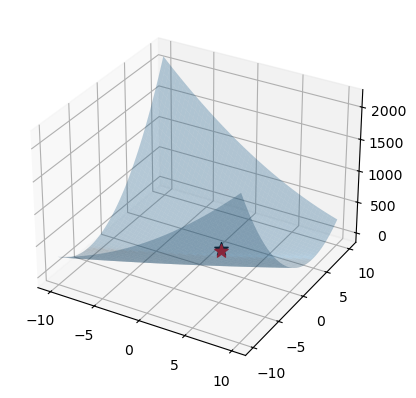

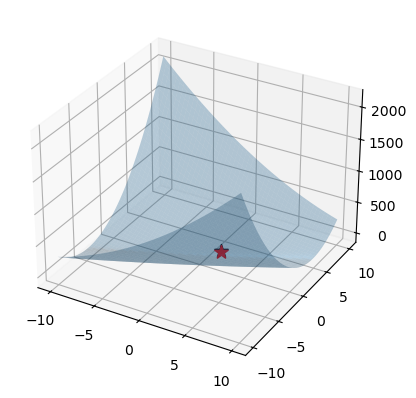

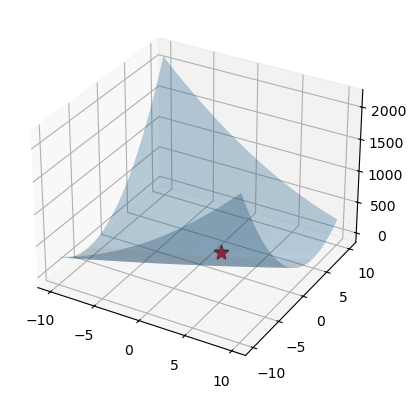

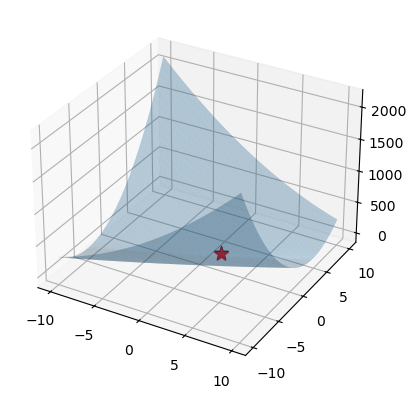

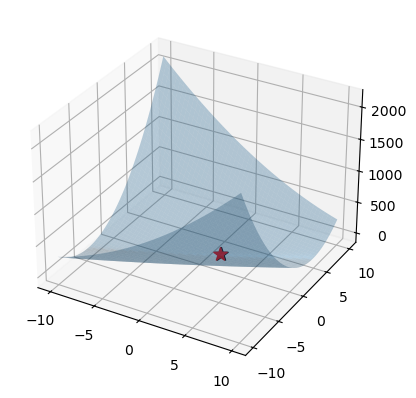

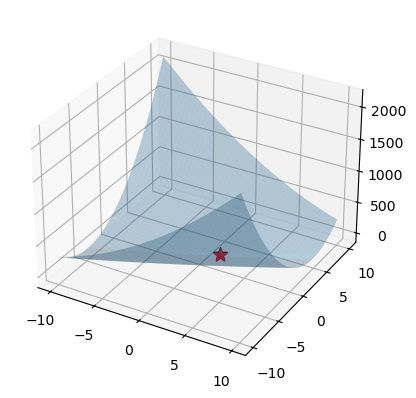

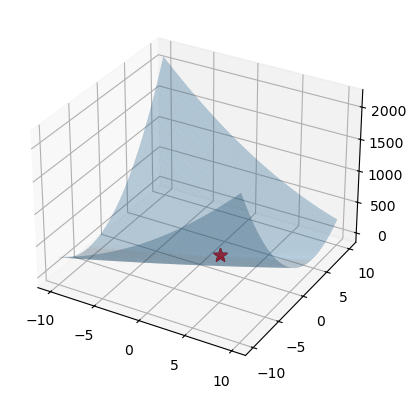

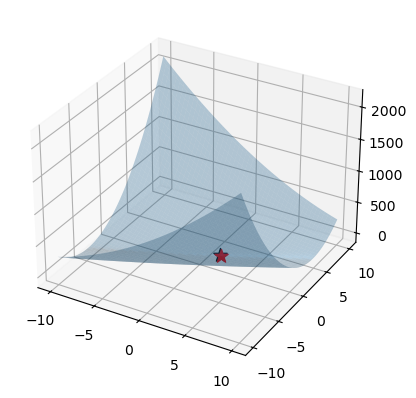

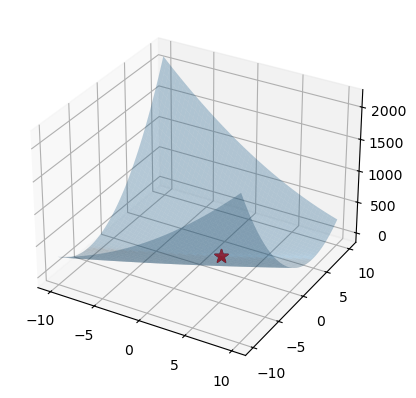

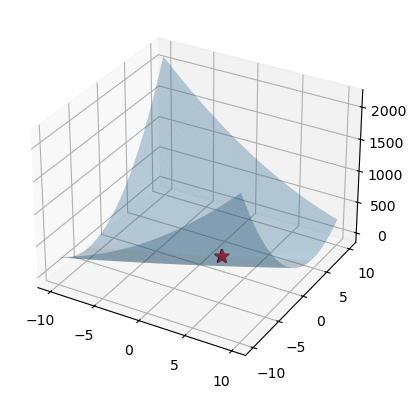

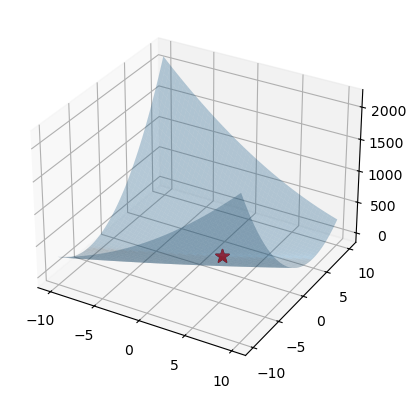

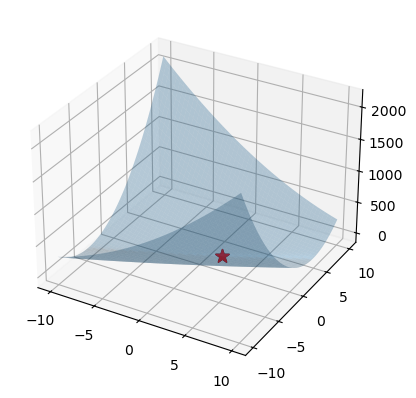

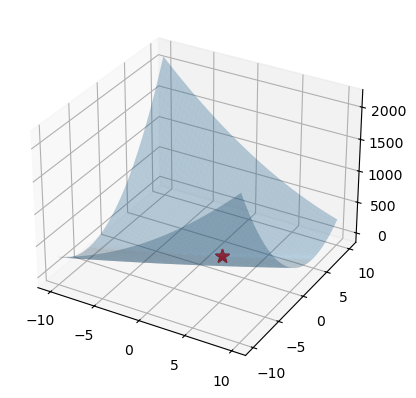

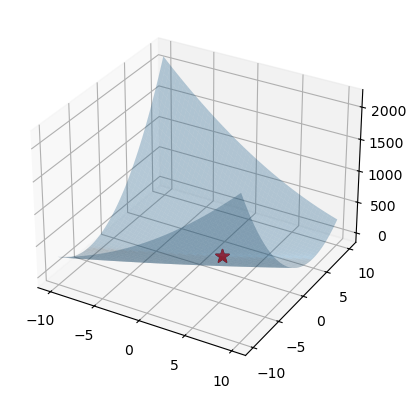

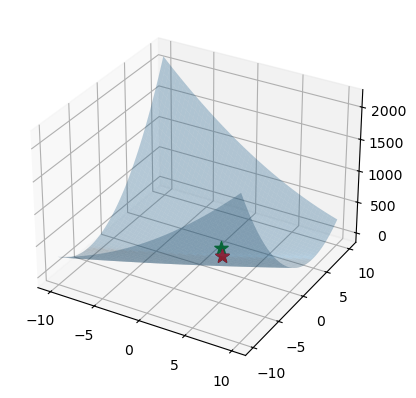

In [27]:
# code for minimizing; this is what I used in class. (Slight alteration to make it work)
best, steps = grad_NDescent(chi,np.array(start,float),.01,4, move = True)
for i in range(steps):
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
    surf = ax.plot_surface(x_plot, y_plot, z, alpha=0.3)
    ax.scatter(best[2*i], best[2*i + 1], chi((best[2*i], best[2*i + 1])), marker="*", s=100, color="r")
    if (i !=0):
        ax.scatter(best[2*i - 2], best[2*i - 1], chi((best[2*i-2], best[2*i - 1])), marker="*", s=100, color="k")
    if (i == steps-1):
        ax.scatter(best[0], best[1], chi((best[2*i-2], best[2*i - 1])), marker="*", s=100, color="green")
        ax.axline((best[0], best[1]), (best[2*i], best[2*i + 1]), linewidth=5, color='purple')

## You're allowed to use scipy now

The point of this course is to increase your understanding of computational techniques at their fundamental level. Now that we've beat minimization to death, you've earned the right to simply use `scipy.optimize.minimize`.

- a) Exercise that right now by using `minimize` in place of gradient descent or Nelder-Meade to find the best fit of the `line` function above. This may seem like you're substituting a single function name, but note `minimize` returns a "result" not a number/array/tuple. You can access the "answer" with `result.x`; the documentation may also be helpful. (10 points)

- b) In a previouse course you should have seen `scipy.optimize.curve_fit`. Fundamentally, curve_fit is also solving a minimization problem under-the-hood. Can it find the best fit parameters of our `line` function? Try it! Note: `curve_fit` expects inputs in the order `(func, xdat, ydat)`, not the order used in class. In testing, I could not make `curve_fit` converge to the right answer, even if I passed it for the initial guess. Can you? Or have we just demonstrated the need for using lower level functions sometimes?! (5 points)

In [19]:
def line(x, m, b):
    return m*np.sin(x) + b

chi = SquareChi(x,y,line)

start = np.array([1,line(1,mguess,bguess)],float)
result = minimize(chi,start)
result.x

array([1.99999987, 0.99999962])

In [20]:
curve_fit(line,x,y)

(array([2., 1.]),
 array([[ 0., -0.],
        [-0.,  0.]]))